In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from typing import Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
#from ggplot import *
from plotnine import *
import nltk 
nltk.download('stopwords') #<-  Likely need this
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dpeskov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Stopwords currently used from nltk, but custom list would be better (e.g. top 1000 ASR'd words)
#these should hopefully be the same as before

#these are calculated from the data
additional_stop = [x[0] for x in [('unk', 74533), ('NULL', 35761), ('the', 3587), ('and', 2949), ('a', 2806), ('to', 2685), ('in', 2103), ('you', 1960), ('or', 1860), ('one', 1712), ('it', 1587), ('on', 1477), 
                                  ('for', 1394), ('that', 1317), ('three', 1312), ('like', 1165), ('oh', 1163), 
                                  ('hundred', 1096), ('of', 1087), ('yeah', 1057), ('uh', 970), ('they', 962),
                                  ('i', 959), ('know', 945), ('right', 938), ('five', 895), ('so', 783), ('here', 766),
                                  ('are', 698), ('is', 690), ('two', 686), ('well', 680), ('h', 679), ('be', 650), 
                                  ('our', 638), ('hi', 609), ('them', 602), ('out', 601), ('he', 594), ('p', 564), 
                                  ('its', 548), ('do', 544), ('then', 543), ('now', 510), ('l', 510), ('e', 503), 
                                  ('no', 496), ('with', 495), ('me', 480), ('who', 476), ('my', 469), ('there', 462), 
                                  ('seven', 451), ('six', 448), ('man', 440), ('seventy', 436), ('thousand', 424), 
                                  ('fifty', 424), ('r', 416), ('sixty', 407), ('had', 405), ('which', 403), ('noise', 402),
                                  ('nineteen', 400), ('nine', 398), ('eight', 397), ('at', 397), ('thirty', 396),
                                  ('this', 396), ('up', 396), ('w', 396), ('over', 390), ('by', 388), ('um', 384), 
                                  ('not', 381), ('non', 375), ('too', 370), ('four', 369), ('an', 366), ('their', 365), 
                                  ('as', 361), ('men', 360), ('she', 356), ('twenty', 352), ('theyre', 350), 
                                  ('him', 345), ('his', 345), ('time', 344), ('have', 340), ('did', 334), 
                                  ('quote', 329), ('n', 327), ('first', 325), ('after', 324), ('point', 324), 
                                  ('forty', 324), ('thats', 322), ('from', 321), ('down', 317)]]
stop_words.extend(additional_stop)
print(len(stop_words), len(set(stop_words)))
stop_words = list(set(stop_words))
stop_words[:5]

278 225


['other', 'ma', 'y', 'aren', 'n']

In [3]:
#function to calculate how often a term maps to junk.  Normalized by # of junk words, as each one adds up to 100%
def get_junk_translations(term: str, tpm: Dict[str, Dict[str, float]]) -> float:
    stopwords = stop_words
    total = 0.0
    count = 0
    for alignment in stopwords:
        if alignment in tpm[term]:
          #  count += 1
            total += tpm[term][alignment]
   #if count != 0:    
        #total = total/count
    return total

#read the translation matrix.  Precomputed with Gyza.
def read_translation_probability_matrix(fp) -> Dict[str, Dict[str, float]]:
    probabilities = defaultdict(lambda: defaultdict(float))
    for line in tqdm(fp):
        w1, w0, prob = line.strip().split()
        probabilities[w0][w1] = float(prob)
    return probabilities

#lex.f2e is the opposite mapping
lex_file = 'lex.e2f'

#these are clean sentences
with open('sent.cln') as fp:
    data = [l for l in fp]
    
tpm = read_translation_probability_matrix(open(lex_file))

968135it [00:02, 396451.15it/s]


In [4]:
c = CountVectorizer()

# fit_transform returns a scipy sparse matrix of dimensions:
#  (number_of_documents, vocab_size)
fitted = c.fit_transform(data)
term_frequencies = np.array(fitted.sum(0)[0])

vocab = ['']*len(c.vocabulary_.keys())
for word, ix in c.vocabulary_.items():
    vocab[ix] = word

array_of_junk_translations = np.array([
    get_junk_translations(term, tpm) for term in tqdm(vocab)
])

100%|██████████| 193910/193910 [00:03<00:00, 51353.66it/s]


In [5]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

In [6]:
#sanity check
print(vocab[50005:50025])
array_of_junk_translations[50005:50025]

['disinherits', 'disintegrate', 'disintegrated', 'disintegrates', 'disintegrating', 'disintegration', 'disinter', 'disinterest', 'disinterested', 'disinterestedly', 'disinterestedness', 'disinterred', 'disinters', 'disir', 'disjecta', 'disjoin', 'disjoint', 'disjointed', 'disjunction', 'disjunctions']


array([0.3333334, 0.2      , 0.       , 0.       , 0.       , 0.0857143,
       1.       , 0.3333333, 0.       , 0.       , 1.       , 1.       ,
       0.       , 0.5      , 1.       , 0.       , 0.2083334, 0.       ,
       0.       , 0.       ])

In [7]:
#filter data to that which we are interested in
count, correct_count, one_count = 0, 0, 0
select_term_frequencies = []
select_array_of_junk_translations = []
select_vocab = []

for ix, word in enumerate(vocab):
    if tpm[word]:
        if max(tpm[word], key=tpm[word].get) == word:
            correct_count +=1
            pass
            #print(tpm[word], word)
        else:
            if term_frequencies[0][ix] > 1:
                select_vocab.append(word)
                select_term_frequencies.append(term_frequencies[0][ix])
                select_array_of_junk_translations.append(array_of_junk_translations[ix])
            else:
                one_count+=1
            #print(tpm[word], word)
    else:
        count +=1
print(f"Issues with {count} vocab")
print(f"Removed {correct_count} self-matching words")   
print(f"Removed {one_count} words that occur once")   

Issues with 2815 vocab
Removed 18427 self-matching words
Removed 94845 words that occur once


In [8]:
bins = [0.0, .25, .50, .75, 1.01]
df = pd.DataFrame({'Word_Log_Term_Frequency': np.log(select_term_frequencies), 'Probability_of_Being_Mapped_to_Junk':select_array_of_junk_translations, 'txt':[(txt +'\n'+ max(tpm[txt], key=tpm[txt].get)) for txt in select_vocab]})
df['binned'] = pd.cut(df['Probability_of_Being_Mapped_to_Junk'], bins,  right = True, include_lowest=True,precision =2)
df['binned_x'] = pd.cut(df['Word_Log_Term_Frequency'], [0, 1, 3, 5, 12], right = True, include_lowest=True)

In [9]:
def get_labels(df):
    sample = df.groupby('binned_x', as_index= False).apply(lambda df: df.sample(100))
    sample_dict = {}
    count = 0
    for ix, item in sample.iterrows():
        #print(item)
        if (item[4] in sample_dict.keys()):
            if item[3] in sample_dict[item[4]]:
                pass
            else: 
                sample_dict[item[4]].update({item[3]:count})
        else:
            sample_dict[item[4]] = {item[3]:count}
        count+=1

    candidates = []
    for keys in sample_dict.keys():
        for a in  sample_dict[keys].keys():
            candidates.append(sample_dict[keys][a])

    labels = sample.iloc[candidates]
    return labels

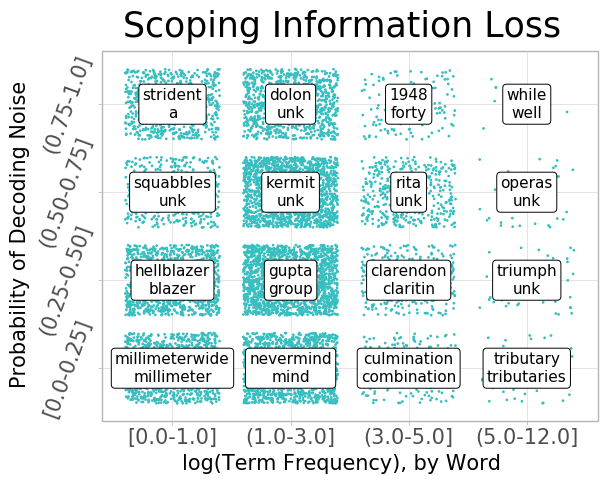

<ggplot: (7566384844)>

In [77]:
df = df.sample(10000)
labels = get_labels(df)
#sample = df.sample(10, axis = 1)

p = ggplot(aes(x='binned_x', y='binned', label = 'txt'), df)\
+ theme_light() \
+ geom_point(aes(),color = "#37BEC0", size = .1, position = 'jitter') \
+ labs(x = 'log(Term Frequency), by Word', y = 'Probability of Decoding Noise', title = "Scoping Information Loss")\
+theme(title = element_text(size = 25))\
+theme(axis_text_x = element_text(size = 15, angle = 0))\
+theme(axis_text_y = element_text(size = 15, angle = 70))\
+theme(axis_title_y = element_text(size = 15, angle = 90))\
+ theme(axis_title_x = element_text(size = 15, angle = 0))\
+ scale_x_discrete(labels = ["[0.0-1.0]", "(1.0-3.0]" , "(3.0-5.0]", "(5.0-12.0]"])\
+ scale_y_discrete(labels = ["[0.0-0.25]", "(0.25-0.50]" , "(0.50-0.75]", "(0.75-1.0]"])\
+ geom_label(labels, size = 11)
p